In [1]:
# processing
import operator
from operator import methodcaller
import csv
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string
import math
import itertools

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import HdpModel
from gensim.models import TfidfModel

# plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

# sci-kit
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import feature_extraction


C:\Users\pjz1\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
blacklist = [t.strip() for t in next(csv.reader(open("tools\\blacklist.csv", 'r')))]
levels = [0, 1, 2, 3]

# format [term, orig, sentence, docID]
inPath = "raw.csv"

inFile = open(inPath, 'r')
inReader = csv.reader(inFile)

docTokens = dict()

# ignore headers
next(inReader)


for inRow in inReader:
    term = inRow[0]
    docID = inRow[3]
    
    
    # find acceptable tokens only
    token = "_".join([t for t in term.split(":") if re.match(r'[^\W\d]*$', t) and not t in blacklist])

    # calculate new term level
    level = token.count("_")

    # if acceptable, add to dictionary
    if level in levels and not token in blacklist and len(token) > 0:
        if docID in docTokens:
            docTokens[docID] += [token]
        else:
            docTokens[docID] = [token]
                        
docIDs = list(docTokens.keys())
texts = list(docTokens.values())


In [4]:
dictionary = corpora.Dictionary(texts)
print(len(dictionary))

dictionary.filter_extremes(no_below=3, no_above=0.25, keep_n=15000)
print(len(dictionary))

corpus = [dictionary.doc2bow(text) for text in texts]


tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

1233
19762
1914


### Coherence Testing

Find the ideal number of topics by performance cohernece tests on sample topic models.

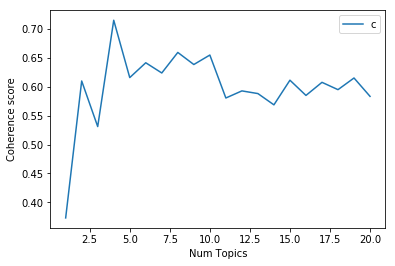

In [7]:
topics = range(1, 21)
passes = 5
iterations = 500

model_list = list()
coherence_values = list()

for topicnum in topics:

    model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=topicnum, id2word=dictionary, passes=passes, workers =4, iterations=iterations)
    model_list.append(model)
    
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


plt.plot(topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()